# Potential Field path planning

First we define the map and initialize a distance map that will store later the smallest distance of each cell from the obstacles in the map.

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from collections import deque

# Define the map size (height, width)
map_height = 200
map_width = 300
binary_map = np.zeros((map_height, map_width), dtype=np.uint8)  # 0: free space, 255: obstacle

Now we create several obstacles using the function fillPoly in opencv. This function allow us to fill a polygon by defining the vertices of the polygon.
We created 5 obstacles. three of them are triangles and two of them are pentagons 

In [2]:
# Define obstacle polygons as a list of points
obstacle1 = np.array([[50, 50], [80, 30], [110, 60], [80, 90], [50, 70]], np.int32)
obstacle2 = np.array([[170, 30], [200, 20], [190, 50]], np.int32)
obstacle3 = np.array([[220, 30], [250, 30], [250, 60], [220, 60], [235, 45]], np.int32)
obstacle4 = np.array([[200, 160], [230, 120], [230, 150]], np.int32)
obstacle5 = np.array([[150,80],[150,120],[130,90]], np.int32)

# Draw the obstacles
cv2.fillPoly(binary_map, [obstacle1], 1)
cv2.fillPoly(binary_map, [obstacle2], 1)
cv2.fillPoly(binary_map, [obstacle3], 1)
cv2.fillPoly(binary_map,[obstacle4], 1)
cv2.fillPoly(binary_map,[obstacle5], 1)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

Visualize the created map with obstacles.

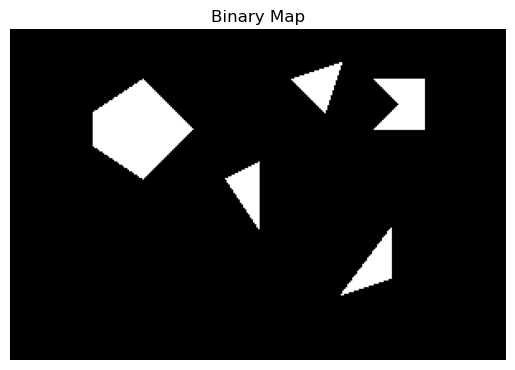

In [3]:
plt.imshow(binary_map, cmap='gray')
plt.title("Binary Map")
plt.axis("off")
plt.show()

## Create distance map

Creating distance map is one of the most important steps in potential field path planning. 
Our approach:
1. Initialize the distance map with big numbers (We are sure that no distance will exceed this number)
2. Fill the obstacles cells with 0.
3. Now we iterate over the elements of the queue as follow:
    1. Pop the last element from the queue.
    2. For this element calculate the distances of the 8 neighbors cells based on the value of this element.
    3. If the new calculated distance of the neighbors is less than the old distance then the distance is updated and this neighbor is pushed into the queue.

When all the distance map cells are correct then no new cells will be pushed into the queue and we finish when the queu is empty. 

In [4]:
def compute_distance_map(binary_map):
    height, width = binary_map.shape
    distance_map = np.full((height, width), 10000) # Initialize the distance map with high value
    
    queue = deque() # create the queue

    # Initialize distance map and queue with obstacle locations
    for x in range(height):
        for y in range(width):
            if binary_map[x, y] == 1:  # Obstacle
                distance_map[x, y] = 0.0 # when we have obstacle the distance is 0
                queue.append((x, y)) # add the obstacle cells to the queue to start from them

    # 8-connected neighbors for Euclidean distance
    neighbors = [(-1, -1), (-1, 0), (-1, 1),
                 ( 0, -1),          ( 0, 1),
                 ( 1, -1), ( 1, 0), ( 1, 1)]

    while queue:
        x, y = queue.popleft() # Poping the last added cell
        for dx, dy in neighbors: # Considering each neighbor of the poped cell
            nx, ny = x + dx, y + dy
            if 0 <= nx < height and 0 <= ny < width:
                # Euclidean distance to the neighbor
                step_distance = np.sqrt(dx**2 + dy**2)
                new_distance = distance_map[x, y] + step_distance

                if new_distance < distance_map[nx, ny]: # updating the distance if the new distance is smaller than the old distance
                    distance_map[nx, ny] = new_distance
                    queue.append((nx, ny))
    
    return distance_map


Now we compute the distance map of our map:

In [5]:
distance_map = compute_distance_map(binary_map)

For safety and to make sure we don't divide by zero, we clip the distance from the buttom by a small number.

In [6]:
def safe_distance_map(distance_map, epsilon=1e-3):
    return np.clip(distance_map, epsilon, None)

After computing the distance for each cell, we can start computing the values of the attractive and repulsive fields in addition to the attractive and repulsive forces.

In [7]:
start = (25,25) # define the starting point
goal = (175, 225) # define the goal point

# function to calculate the attractive field for the map
def attrac_field(binary_map,k_att = 0.1):
    height, width = binary_map.shape
    attrac_field_map = np.zeros((height,width)) # we initialize the attractive field map with zeros

    for x in range(height):
        for y in range(width):
            # for each cell we calculate the attractive field based on its location and the goal location.
            attrac_field_map [x,y] = 0.5 * k_att * np.linalg.norm(np.array((x,y)) - np.array(goal)) 
    return attrac_field_map

# function to calculate the repulsive field for the map
def repul_field(binary_map, distance_map, k_repul=50.0, tolerance=20):
    height, width = binary_map.shape
    repul_field_map = np.zeros((height, width)) # we initialize the repulsive field map with zeros
    safe_dist = safe_distance_map(distance_map) # get the distance map

    for x in range(height):
        for y in range(width):
            d = safe_dist[x, y]
            if d > tolerance: # if the cell is not close enough to the obstacle then then the repulsive field is 0 at this cell.
                continue
            # if the cell is close enough to the obstacle then the repulsive field at this point is calculated as follows:
            repul_field_map[x, y] = 0.5 * k_repul * ((1/d - 1/tolerance) ** 2)
    return repul_field_map

# function to calculate the attractive force for the map
def attrac_power(binary_map, k_att = 0.1):
    height, width = binary_map.shape
    attrac_force_map = np.zeros((height,width,2)) # The attractive force is a vector not a scaler like the attractive field.

    for x in range(height):
        for y in range(width):
            attrac_force_map [x,y] = - k_att * (np.array((x,y)) - np.array(goal)) # The formula of the attractive force at each cell.
    return attrac_force_map

# function to calculate the repulsive force for the map
def repul_force(binary_map, distance_map, gradient, k_repul=50.0, tolerance=20):
    height, width = binary_map.shape
    repul_force_map = np.zeros((height, width, 2)) # The repulsive force is also a vector.
    safe_dist = safe_distance_map(distance_map)

    for x in range(height):
        for y in range(width):
            d = safe_dist[x, y]
            if d > tolerance:
                continue
            factor = - k_repul * ((1/d) - (1/tolerance)) * (1/d**2) # The formula of the attractive force at each cell close enough to the obstacle.
            repul_force_map[x, y] = factor * gradient[x, y]
    return repul_force_map


attrac_field_map = attrac_field(binary_map)# the attractive field of the whole map
repul_field_map = repul_field(binary_map, distance_map) # the repulsive field of the whole map
attrac_force_map = attrac_power(binary_map)# the attractive force of the whole map

# in the repulsive force formula, we need the gradient of the distance map. Thus we use the function np.gradient that returns the gradient along the x and y axes. 
grad_y, grad_x = np.gradient(distance_map)
gradient = np.stack((grad_x, grad_y), axis=-1)
repul_force_map = repul_force(binary_map, distance_map, gradient) # the repulsive force of the whole map

total_field_map = attrac_field_map + repul_field_map # The sum of the two fields (attractive and repulsive)
total_force = attrac_force_map + repul_force_map # The sum of the two forces (attractive and repulsive)

# Here we compute the gradient of the total field (We can use this or the total_force)
grad_y, grad_x = np.gradient(total_field_map)
total_field_map_gradient = np.stack((grad_x, grad_y), axis=-1)

This function to visualize the fields that we created to make sure there is no error.

In [8]:
import matplotlib.pyplot as plt

def plot_3d_field(field, title="3D Field"):
    x = np.arange(field.shape[1])
    y = np.arange(field.shape[0])
    X, Y = np.meshgrid(x, y) # mesh creation

    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')

    ax.plot_surface(X, Y, field, cmap='viridis', edgecolor='k', linewidth=0.2) #plotting the field
    ax.set_title(title)
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Field Value")

    plt.tight_layout()
    plt.show()

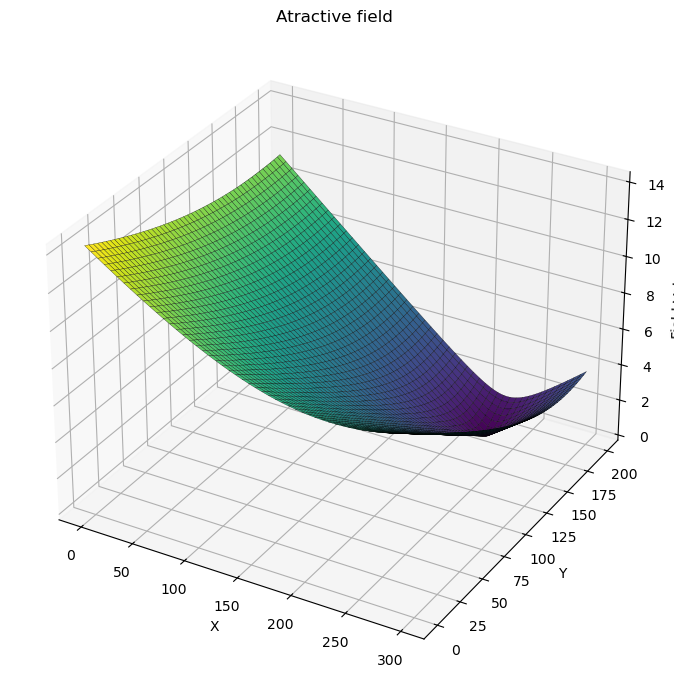

In [9]:
plot_3d_field(attrac_field_map,'Atractive field')

We can notice that the goal is the lowest point.

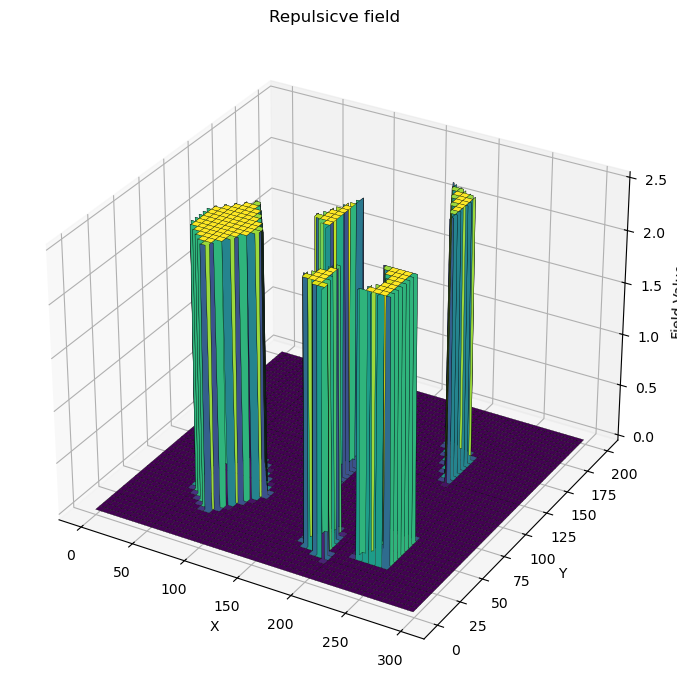

In [10]:
plot_3d_field((repul_field_map),'Repulsicve field')

As we expected the Repulsive field is zero if we are far from the obstacles.

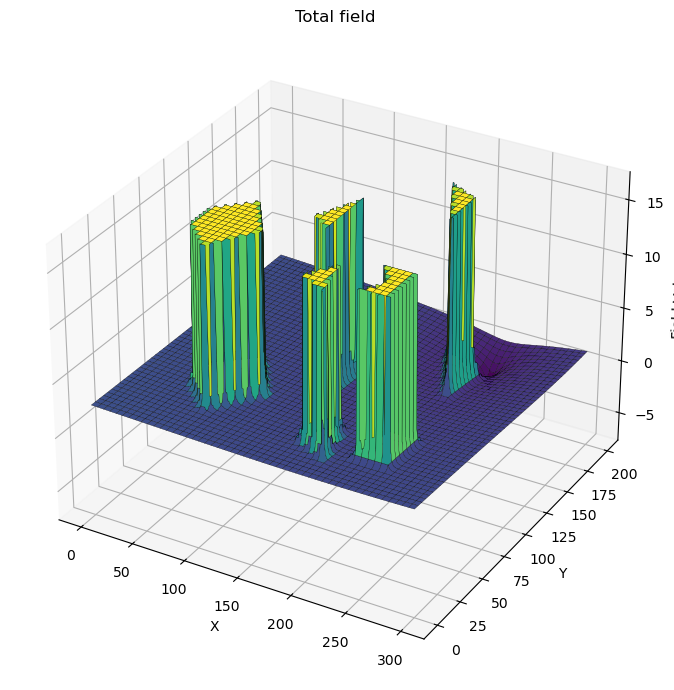

In [11]:
plot_3d_field(np.log(total_field_map),'Total field')

At this point we have the total field at each cell and the force magnitude and direction at each cell also. We need a procedure to move the robot and create the path. We need to move in the opposite direction of the graient of the total field (in the opposite direction of the total force). Thus from the start point we update our position using the opposite direction of the gradient multiplied by a learning rate.

In [12]:
def follow_force_field(force_field, start, goal, step_size=5, threshold=1.5, max_iters=10000000):
    path = []
    p = np.array(start, dtype=float)
    goal = np.array(goal, dtype=float)

    for _ in range(max_iters):
        path.append(p.copy())
        i, j = int(round(p[1])), int(round(p[0]))  # row = y, col = x

        # Check bounds
        if i < 0 or i >= force_field.shape[0] or j < 0 or j >= force_field.shape[1]:
            print("Out of bounds")
            break

        f = force_field[i, j]
        norm = np.linalg.norm(f) 
        if norm < 1e-5: # If the amplitude of the gradient is small then we either reached the goal or got stuck in local minimum. 
            print("Force vanished — possible local minimum")
            break

        direction = f / norm
        p += step_size * direction # updating the location of the robot 

        if np.linalg.norm(p - goal) < threshold: # Wher we are very close to the goal we terminate and consider the goal reached.
            path.append(goal)
            break

    return np.array(path)


Function to visualize the path along side the map.

In [13]:
def plot_path_on_field(field, path, title="Potential Field with Path"):
    plt.figure(figsize=(8, 6))
    plt.imshow(field, cmap='viridis', origin='lower')
    plt.plot(path[:, 0], path[:, 1], color='red', linewidth=1, label="Path")
    plt.scatter(path[0, 0], path[0, 1], color='green', label='Start')
    plt.scatter(path[-1, 0], path[-1, 1], color='blue', label='Goal')
    plt.legend()
    plt.title(title)
    plt.xlabel("Y")
    plt.ylabel("X")
    plt.grid(True)
    plt.show()


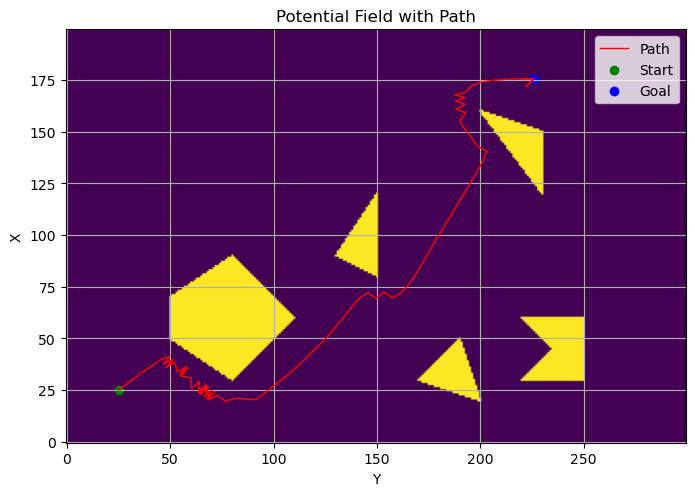

In [14]:
path = follow_force_field(-total_field_map_gradient,start,goal)
plot_path_on_field (total_field_map,path)

As you can notice the robot reached the goal successfully. This might not be the case for any goal and any start point because we might face local minimum. Local minimum happens when the value of the repulsive force is equal and the opposite direction of the attractive force. In this case the robot does not have a direction to go along side. There are several solution to this problem that we can add to our implementation.

The easiest soltution is to add a small random force or displacement when the robot’s movement falls below a threshold (i.e., it’s stuck). This random movement might get the robot out of the local minimum area.Another idea is to add local virtual obstacles or enlarge obstacles to get out of local minimum.

In general potential field can also be used as a local planner to aviode obstacles and smooth the path while the global planner is A* or RRT.